## Mathematical Formulation

$min_{\gamma,w,b} \frac{1}{2} \vert\vert w \vert\vert ^{2} + C \sum_{i=1}^{m} \xi_{i}$

$min_{\gamma,w,b} \frac{1}{2} \vert\vert w \vert\vert ^{2} + C 1^T\xi$

$ s.t.$ 

$ y^{(i)}(w^T x^{(i)} + b) \geq 1 - \xi_{i} , i=1,2,...m $

$ \xi_{i} \geq 0 , i=1,2,...m $

$ max_\alpha \sum_{i=1}^{m} \alpha_{i} - \frac{1}{2} \sum_{i,j=1}^{m} y^{(i)}y^{(j)}\alpha_{i}\alpha_{j}<x^{(i)},x^{(j)}>$

$ s.t.$ 

$ 0 \leq \alpha_{i} \leq C_{i}, i=1,2,...m $

$  \sum_{i=1}^{m} \alpha_{i} y^{(i)} = 0 $

### Importing Libraries

In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import time, os

### Generating Data

In [2]:
DIM = 2
COLORS = ['red', 'blue']

# 2-D mean of ones
M1 = np.ones((DIM,))
# 2-D mean of threes
M2 = 2 * np.ones((DIM,))
# 2-D covariance of 0.3
C1 = np.diag(0.3 * np.ones((DIM,)))
# 2-D covariance of 0.2
C2 = np.diag(0.2 * np.ones((DIM,)))

def generate_gaussian(m, c, num):
    return np.random.multivariate_normal(m, c, num)

NUM = 50
if __name__ == '__main__':
    # generate 50 points from gaussian 1
    x1 = generate_gaussian(M1, C1, NUM)
    x1_test = generate_gaussian(M1,C1,int(NUM/2))
    # labels
    y1 = np.ones((x1.shape[0],))
    y1_test = np.ones((int(x1_test.shape[0]),))
    # generate 50 points from gaussian 2
    x2 = generate_gaussian(M2, C2, NUM)
    x2_test = generate_gaussian(M2,C2,int(NUM/2))
    y2 = -np.ones((x2.shape[0],))
    y2_test = -np.ones((int(x2_test.shape[0]),))
    # join
    x = np.concatenate((x1, x2), axis = 0)
    y = np.concatenate((y1, y2), axis = 0)
    x_test = np.concatenate((x1_test,x2_test),axis = 0)
    y_test = np.concatenate((y1_test,y2_test),axis = 0)
    print('x {} y {}'.format(x.shape, y.shape))
    print('x_test {} y_test {}'.format(x_test.shape, y_test.shape))
    # write
    #with open('gaussiandata.pickle', 'wb') as f:
    #    pickle.dump((x, y), f)

x (100, 2) y (100,)
x_test (50, 2) y_test (50,)


### Plotting Functions

In [3]:
def plot_data_with_labels(x, y, ax=None):
    unique = np.unique(y)
    if ax==None:
        fig,ax = plt.subplots()
    for li in range(len(unique)):
        x_sub = x[y == unique[li]]
        ax.scatter(x_sub[:, 0], x_sub[:, 1], c = COLORS[li])
    plt.show()

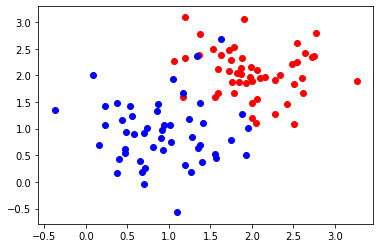

In [4]:
plot_data_with_labels(x, y)

In [5]:
def plot_separator(ax, w, b): 
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    minpt = np.min(x[:,0])
    maxpt = np.max(x[:,0])
    sep_min = minpt*slope+intercept
    sep_max = maxpt*slope+intercept
    ax.plot([minpt,maxpt], [sep_min,sep_max], 'k-')

In [6]:
def plot_margins(ax, w, b):
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    minpt = np.min(x[:,0])
    maxpt = np.max(x[:,0])
    margin_up_min = slope*minpt+intercept+1/w[1]
    margin_up_max = slope*maxpt+intercept+1/w[1]
    margin_down_min = slope*minpt+intercept-1/w[1]
    margin_down_max = slope*maxpt+intercept-1/w[1]
    
    ax.plot([minpt,maxpt],[margin_up_min,margin_up_max],'--',color='gray')
    ax.plot([minpt,maxpt],[margin_down_min,margin_down_max],'--',color='gray')

# Primal

### Declaring Variables and Parameters

In [7]:
w = cp.Variable(DIM)
b = cp.Variable()
Xi = cp.Variable(2*NUM) #Length equal to total number of samples

Cp = cp.Parameter()
Cp.value = 0.6

### Declaring the Constraints

In [8]:
x_constraints = [y[i]*(w.T@x[i]+b) >= 1 - Xi[i] for i in range(2*NUM)]
Xi_constraints = [Xi[i]>=0 for i in range(2*NUM)]

constraints = x_constraints + Xi_constraints

### Declaring the Objective Function

In [9]:
objective = cp.Minimize(0.5*cp.norm(w,2)+Cp*(np.ones(2*NUM)@Xi))

### Declaring the Problem instance

In [10]:
prob = cp.Problem(objective,constraints)

### Final nail!!!

In [11]:
optimal_w = None
optimal_b = None

Cp.value = 0.95
stime = time.time()
prob.solve()

optimal_w = w.value
optimal_b = b.value

print("Problem Status : "+prob.status)
print("Objective Function Value : ",prob.value)
print("Time Taken : ",time.time()-stime," seconds\n")

Problem Status : optimal
Objective Function Value :  15.740554609219519
Time Taken :  0.31200718879699707  seconds



In [12]:
print("Optimal Value of w : ",optimal_w)
print("Optimal Value of b : ",optimal_b)

Optimal Value of w :  [-2.16779649 -1.89337913]
Optimal Value of b :  6.143287321872118


In [25]:
print("Training Accuracy : ",end=" ")
print(np.count_nonzero([y[i]*(w.value@x[i,:].T+b.value)>=0 for i in range(2*NUM)])/(2*NUM))

Training Accuracy :  0.95


In [24]:
print("Test Accuracy : ")
print(np.count_nonzero([y_test[i]*(w.value@x_test[i,:].T+b.value)>=0 for i in range(NUM)])/int(NUM))

Test Accuracy : 
0.94


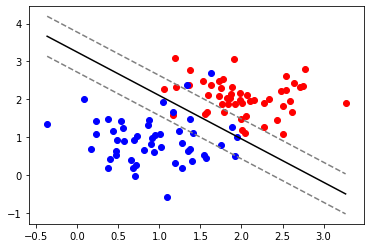

In [15]:
# show data and w
fig, ax = plt.subplots()
plot_separator(ax, optimal_w, optimal_b)
plot_margins(ax,optimal_w,optimal_b)
plot_data_with_labels(x, y, ax)
plt.show()

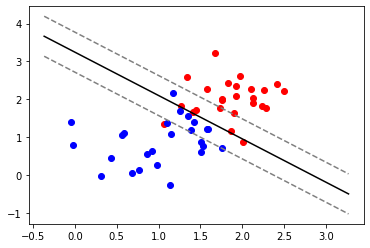

In [16]:
fig, ax = plt.subplots()
plot_separator(ax, optimal_w, optimal_b)
plot_margins(ax,optimal_w,optimal_b)
plot_data_with_labels(x_test, y_test, ax)
plt.show()

In [17]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

from sklearn import svm

clf = svm.SVC(kernel='linear',C=1-0.05)
clf.fit(x,y)

SVC(C=0.95, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [18]:
print(clf.coef_[0],clf.intercept_)

[-1.69314349 -1.58813166] [4.96198224]


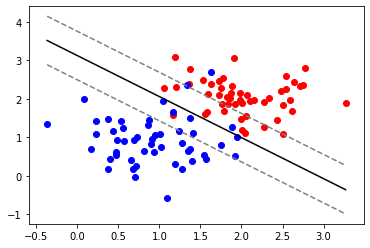

In [19]:
w1 = clf.coef_[0]
b1 = clf.intercept_
fig1, ax1 = plt.subplots()
plot_separator(ax1,w1,b1)
plot_margins(ax1,w1,b1)
plot_data_with_labels(x, y, ax1)
plt.show()

In [20]:
print("Training Accuracy: ", clf.score(x,y))

Training Accuracy:  0.96


In [21]:
clf.score(x_test,y_test)

0.94

#### It is evident that the result obtained using cvxpy is almost same as returned by sklearn.svm.SVC 

# Dual

In [26]:
def get_weights_and_bias(alphas):
    # get weights
    w = np.sum(alphas.value @ y[:, None] * x, axis = 0)
    # get bias
    cond = (alphas.value > 1e-4).reshape(-1)
    b = y[cond] - np.dot(x[cond], w)
    bias = b[0]
    return (w,b)

In [27]:
alphas = cp.Variable((2*NUM,1))
Cd = cp.Parameter()
Cd.value = 0.95

In [28]:
alphas_constraint_1 = [alphas[i] >= 0 for i in range(2*NUM)]
alphas_constraint_2 = [alphas[i] <= Cd for i in range(2*NUM)]
alpha_y_constraint = [cp.sum([alphas[i]*y[i] for i in range(2*NUM)]) == 0]

constraints_dual = alphas_constraint_1 + alphas_constraint_2 + alpha_y_constraint

In [29]:
K = y[:,None]*x
K = np.dot(K,K.T)

In [30]:
cp.multiply(y[:,None],alphas).T.shape

(1, 100)

In [31]:
objective_dual = cp.Minimize(cp.sum(alphas)-alphas.T@K@alphas)

In [32]:
prob_dual = cp.Problem(objective_dual,constraints)

In [33]:
optimal_w = None
optimal_b = None

Cd.value = 0.95
stime = time.time()
prob_dual.solve()
print("Problem Status : "+prob_dual.status)
print("Objective Function Value : ",prob_dual.value)
print("Time Taken : ",time.time()-stime," seconds\n")

DCPError: Problem does not follow DCP rules. Specifically:
The objective is not DCP. Its following subexpressions are not:
var3420.T @ [[ 1.83491803  1.75045974  2.28622267 ... -4.39732493 -5.00052443
  -3.77439719]
 [ 1.75045974  2.34203535  2.34179792 ... -5.44176538 -5.89979043
  -4.35890149]
 [ 2.28622267  2.34179792  2.8869991  ... -5.77716101 -6.50063002
  -4.88412578]
 ...
 [-4.39732493 -5.44176538 -5.77716101 ... 12.85096644 14.07871791
  10.45176273]
 [-5.00052443 -5.89979043 -6.50063002 ... 14.07871791 15.52527056
  11.56008668]
 [-3.77439719 -4.35890149 -4.88412578 ... 10.45176273 11.56008668
   8.61922173]] @ var3420

In [111]:
print(alphas.value)

None


In [109]:
optimal_w,optimal_b = get_weights_and_bias(alphas)
print("Optimal Value of w : ",optimal_w)
print("Optimal Value of b : ",optimal_b)

ValueError: matmul: Input operand 0 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [ ]:
print("Training Accuracy : ",end=" ")
print(np.count_nonzero([y[i]*(w.value@x[i,:].T+b.value)>=0 for i in range(2*NUM)])/(2*NUM))

In [ ]:
print("Test Accuracy : ")
print(np.count_nonzero([y_test[i]*(w.value*x_test[i,:].T+b.value)>=0 for i in range(int(2*NUM/10))])/int(2*NUM/10))

In [ ]:
# show data and w
fig, ax = plt.subplots()
plot_separator(ax, optimal_w, optimal_b)
plot_margins(ax,optimal_w,optimal_b)
plot_data_with_labels(x, y, ax)
plt.show()